For the final capstone I decided to do image recognition in 5 different types of crops. The data comes from kaggle @ https://www.kaggle.com/code/drvtalan/cnn-agri-crops

In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the paths to your image folders
train_data_dir = "C:/Users/Trenton/Documents/GitHub/crop classification/crop_images"
test_data_dir = "C:/Users/Trenton/Documents/GitHub/crop classification/test_crop_image"

# Parameters for image loading and preprocessing
batch_size = 32
image_size = (128, 128)  # Resize images to this size

# data loading and augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,       # Normalize pixel values to [0, 1]
    rotation_range=20,       # Randomly rotate images
    width_shift_range=0.2,   # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill any new pixels with the nearest neighbor
)

# Load and preprocess the training data
combined_train_data_generator = datagen.flow_from_directory(
    train_data_dir,  
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # multi-class classification
    shuffle=True              # Shuffle the data during training
)

# Load and preprocess the test data
test_generator = datagen.flow_from_directory(
    test_data_dir,    
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False              # No need to shuffle test data
)

# Print the class labels
class_labels = list(combined_train_data_generator.class_indices.keys())
print("Class Labels:", class_labels)


Found 201 images belonging to 5 classes.
Found 0 images belonging to 0 classes.
Class Labels: ['jute', 'maize', 'rice', 'sugarcane', 'wheat']


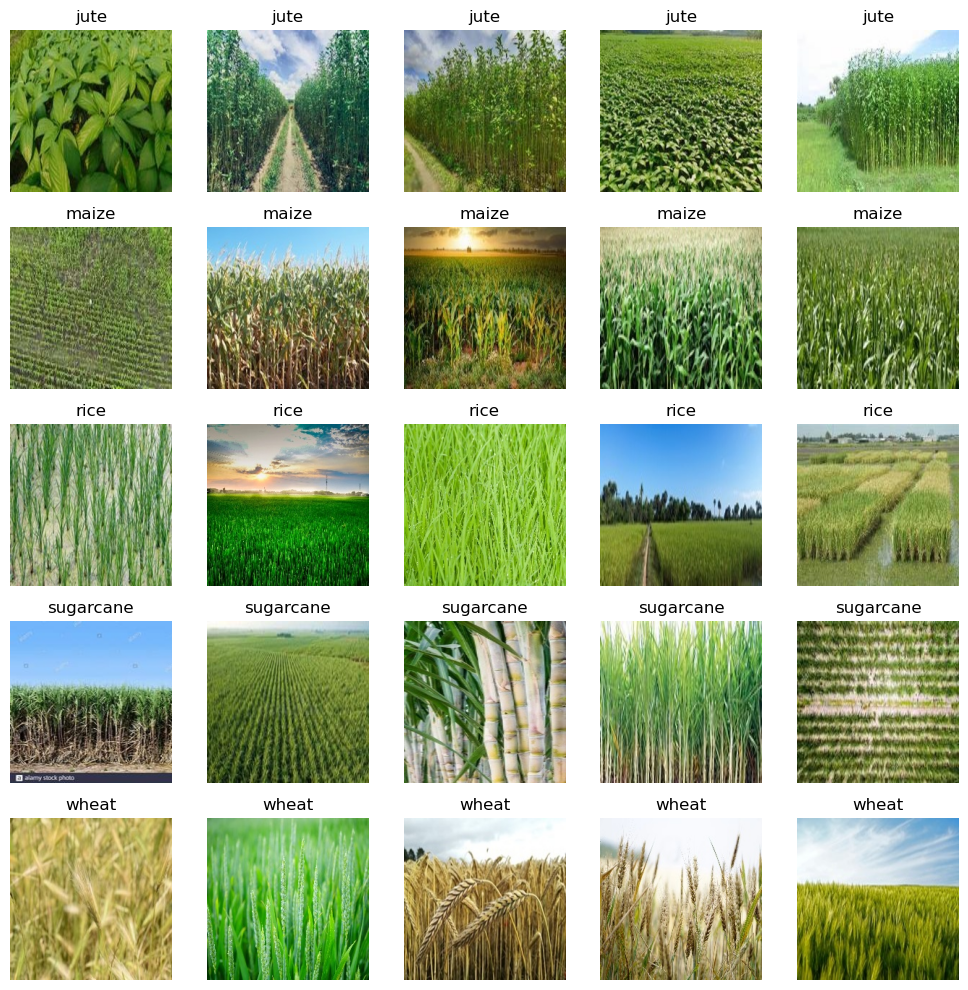

Total Images: 201
Class: jute, Count: 40
Class: maize, Count: 40
Class: rice, Count: 40
Class: sugarcane, Count: 40
Class: wheat, Count: 41


In [15]:
from PIL import Image


# Get the list of class labels
class_labels = sorted(os.listdir(train_data_dir))

# Initialize variables for data summary
total_images = 0
class_counts = []

# Loop through each class to count images and display sample images
plt.figure(figsize=(10, 10))
for class_label in class_labels:
    class_dir = os.path.join(train_data_dir, class_label)
    image_files = os.listdir(class_dir)
    class_count = len(image_files)
    
    # Display sample images
    sample_images = np.random.choice(image_files, size=5, replace=False)
    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(class_dir, image_name)
        image = Image.open(image_path)
        plt.subplot(len(class_labels), 5, i + 1 + class_labels.index(class_label) * 5)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    
    # Update data summary
    total_images += class_count
    class_counts.append(class_count)

plt.tight_layout()
plt.show()

# Print data summary
print("Total Images:", total_images)
for i, class_label in enumerate(class_labels):
    print(f"Class: {class_label}, Count: {class_counts[i]}")


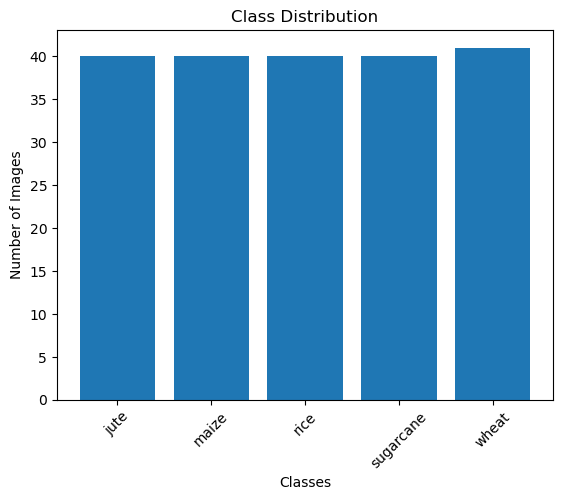

In [16]:
# Calculate class distribution
class_counts = [len(os.listdir(os.path.join(train_data_dir, class_name))) for class_name in class_labels]
plt.bar(class_labels, class_counts)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

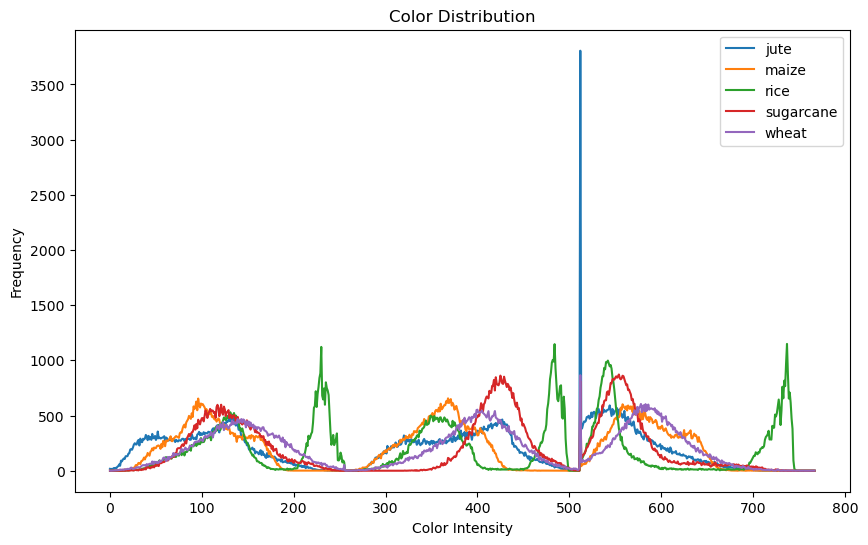

In [17]:
# Initialize color histograms
color_histograms = {class_label: [] for class_label in class_labels}

# Loop through each class to compute color histograms
for class_label in class_labels:
    class_dir = os.path.join(train_data_dir, class_label)
    image_files = os.listdir(class_dir)
    
    for image_name in image_files:
        image_path = os.path.join(class_dir, image_name)
        image = Image.open(image_path)
        image = image.convert("RGB")
        image_array = np.array(image)
        
        # Compute color histograms for each channel (R, G, B)
        color_hist_r = np.histogram(image_array[:, :, 0], bins=256, range=(0, 256))[0]
        color_hist_g = np.histogram(image_array[:, :, 1], bins=256, range=(0, 256))[0]
        color_hist_b = np.histogram(image_array[:, :, 2], bins=256, range=(0, 256))[0]
        
        # Combine histograms for all channels
        color_hist = np.concatenate((color_hist_r, color_hist_g, color_hist_b))
        color_histograms[class_label].append(color_hist)

# Plot color histograms for a few sample images
plt.figure(figsize=(10, 6))
for class_label in class_labels:
    class_color_histograms = color_histograms[class_label]
    sample_color_histogram = class_color_histograms[np.random.choice(len(class_color_histograms))]
    plt.plot(sample_color_histogram, label=class_label)

plt.xlabel("Color Intensity")
plt.ylabel("Frequency")
plt.title("Color Distribution")
plt.legend()
plt.show()


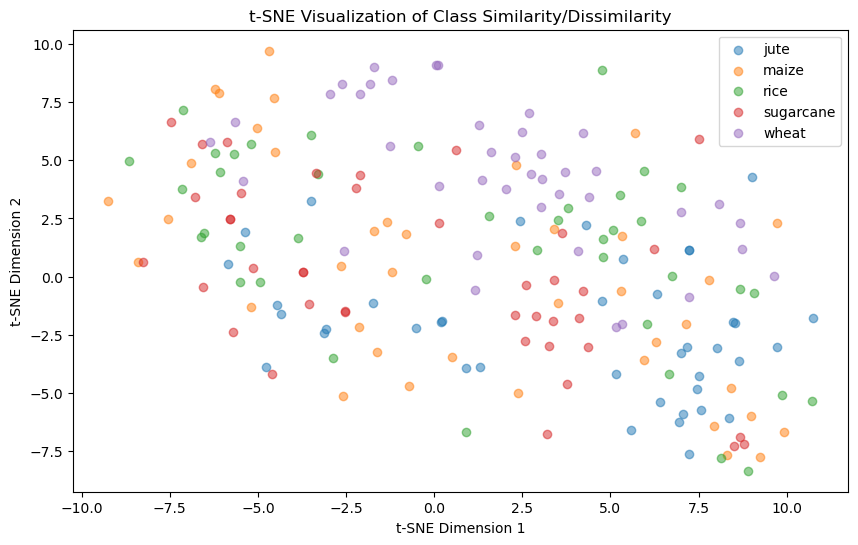

In [21]:
from sklearn.manifold import TSNE
import warnings

# Initialize data and labels arrays
data = []
labels = []

# Loop through each class to collect data for t-SNE
for class_label in class_labels:
    class_dir = os.path.join(train_data_dir, class_label)
    image_files = os.listdir(class_dir)
    
    for image_name in image_files:
        image_path = os.path.join(class_dir, image_name)
        image = Image.open(image_path)
        image_array = np.array(image)
        data.append(image_array.flatten())
        labels.append(class_label)

# Convert lists to arrays
data = np.array(data)
labels = np.array(labels)

# Suppress FutureWarnings temporarily
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    data_tsne = tsne.fit_transform(data)

# t-SNE visualization
plt.figure(figsize=(10, 6))
for class_label in class_labels:
    mask = labels == class_label
    plt.scatter(data_tsne[mask, 0], data_tsne[mask, 1], label=class_label, alpha=0.5)

plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Class Similarity/Dissimilarity")
plt.legend()
plt.show()
